In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [14]:
with open("Ising_2D_h_dist_1675816883", "rb") as fp:   # Unpickling
    h_dist_list = pickle.load(fp)

(array([864., 295.,  94.,  31.,  10.,   4.,   1.,   0.,   0.,   1.]),
 array([7.25816563e-04, 1.35317129e+00, 2.70561676e+00, 4.05806223e+00,
        5.41050770e+00, 6.76295317e+00, 8.11539864e+00, 9.46784411e+00,
        1.08202896e+01, 1.21727351e+01, 1.35251805e+01]),
 <BarContainer object of 10 artists>)

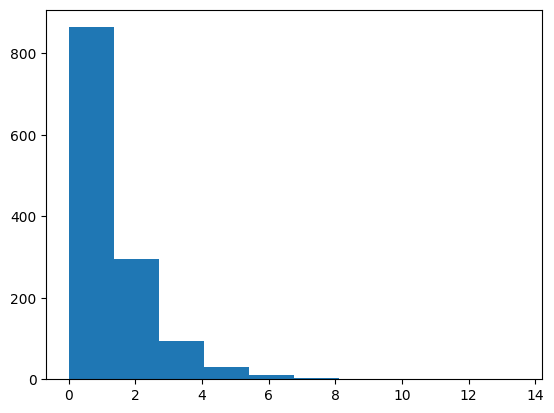

In [19]:
plt.hist(h_dist_list[-2])

In [16]:
with open("Ising_2D_input_1675816883", "rb") as fp:   # Unpickling
    input_dict = pickle.load(fp)

In [17]:
input_dict

{'L': 30,
 'steps': 855,
 'measure_list': array([900, 769, 658, 562, 481, 411, 351, 300, 257, 220, 188, 160, 137,
        117, 100,  86,  73,  62,  53,  46]),
 '(a,b)': (0.1, 0.1),
 'n_runs': 40}